## Cat vs Dog (Classification)

In this notebook, I will build a model that classify an image whether there is/are cat(s) or dog(s) in it.

Also, I will try out:
- TensorBoard
- Reducing Learning Rate during training while monitoring certain metrics

This is Convnet with RMSprop as optimizer.

Feel free to give comment or feedback if any via Discord `nelsonwong98#1244` on how I can improve or mistake made, will appreciate it!


Reference: 
* https://www.kaggle.com/bishabpokharel/dogs-cats-with-fine-tuned-vgg16-cnn
* https://www.kaggle.com/kouwis/catsvsdogs-cnn/data


Check CUDA GPU availability

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Packages needed

In [2]:
import numpy as np
import glob
import shutil
import cv2
import os
import datetime
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6) # (w, h)

In [3]:
%load_ext tensorboard
# %reload_ext tensorboard

### Dataset sorting

Dataset source: https://www.kaggle.com/biaiscience/dogs-vs-cats

Run once only!

### Making directories

In [4]:
original_dataset= "../../../Datasets/cats-vs-dogs/"
base_dir= "../../../Datasets/cats-vs-dogs/working/"

In [ ]:
os.mkdir(base_dir)

train_dir=os.path.join(base_dir,'train/')
os.mkdir(train_dir)
test_dir=os.path.join(base_dir,'test/')
os.mkdir(test_dir)
validation_dir=os.path.join(base_dir,'validation/')
os.mkdir(validation_dir)

train_cat_dir=os.path.join(train_dir,'cat/')
os.mkdir(train_cat_dir)
test_cat_dir=os.path.join(test_dir,'cat/')
os.mkdir(test_cat_dir)
validation_cat_dir=os.path.join(validation_dir,'cat/')
os.mkdir(validation_cat_dir)

train_dog_dir=os.path.join(train_dir,'dog/')
os.mkdir(train_dog_dir)
test_dog_dir=os.path.join(test_dir,'dog/')
os.mkdir(test_dog_dir)
validation_dog_dir=os.path.join(validation_dir,'dog/')
os.mkdir(validation_dog_dir)

### Original Directory

In [5]:
original_train_dataset = original_dataset + "train/"
original_test_dataset = original_dataset + "test/"

sizeof_original_train_val_dataset = len(os.listdir(original_train_dataset))
sizeof_original_test_dataset = len(os.listdir(original_test_dataset))

sizeof_original_train_dataset = int(sizeof_original_train_val_dataset * 0.8)
sizeof_original_val_dataset = sizeof_original_train_val_dataset - sizeof_original_train_dataset

fname_dog_len = int(len(glob.glob(original_train_dataset+ "/dog.*.jpg"))) # Filename with "Dog"
fname_dog_train_len = int(fname_dog_len * 0.8)
fname_dog_val_len = int(fname_dog_len - fname_dog_train_len)

fname_cat_len = int(len(glob.glob(original_train_dataset+ "/cat.*.jpg"))) # Filename with "Cat"
fname_cat_train_len = int(fname_cat_len * 0.8)
fname_cat_val_len = int(fname_cat_len - fname_cat_train_len)

print("Total original training + validation (before split) images count:", sizeof_original_train_val_dataset)
print("Total original training (after split) images count:", sizeof_original_train_dataset)
print("Total original validation (before split) images count:", sizeof_original_val_dataset)

print("\nTotal original training images count(Dog):", fname_dog_len)
print("Total original training images count(Cat):", fname_cat_len)

print("\nTotal original training images count(Dog) :", fname_dog_train_len)
print("Total original training images count(Cat) :", fname_cat_train_len)
print("Total original validation images count(Dog) :", fname_dog_val_len)
print("Total original validation images count(Cat) :", fname_cat_val_len)
print("\nTotal original test images count:", sizeof_original_test_dataset)


Total original training + validation (before split) images count: 25000
Total original training (after split) images count: 20000
Total original validation (before split) images count: 5000

Total original training images count(Dog): 12500
Total original training images count(Cat): 12500

Total original training images count(Dog) : 10000
Total original training images count(Cat) : 10000
Total original validation images count(Dog) : 2500
Total original validation images count(Cat) : 2500

Total original test images count: 12500


### Let's move the corresponding files to their respective places.

From train folder, split:
- 80% - Training
- 20% - Validation

Test folder's images will be used for testing.

### For Training and Validation

In [151]:
dfile=['dog.{}.jpg'.format(i) for i in range(fname_dog_train_len)]
for c in dfile:
    src=os.path.join(original_train_dataset,c)
    dst=os.path.join(train_dog_dir,c)
    shutil.copyfile(src,dst)

dfile=['dog.{}.jpg'.format(i) for i in range(fname_dog_train_len,fname_dog_len)]
for c in dfile:
    src=os.path.join(original_train_dataset,c)
    dst=os.path.join(validation_dog_dir,c)
    shutil.copyfile(src,dst)
    
cfile=['cat.{}.jpg'.format(i) for i in range(fname_cat_train_len)]
for c in cfile:
    src=os.path.join(original_train_dataset,c)
    dst=os.path.join(train_cat_dir,c)
    shutil.copyfile(src,dst)

cfile=['cat.{}.jpg'.format(i) for i in range(fname_cat_train_len,fname_cat_len)]
for c in cfile:
    src=os.path.join(original_train_dataset,c)
    dst=os.path.join(validation_cat_dir,c)
    shutil.copyfile(src,dst)

#### Now that we done splitting classes according to train-validation-test, next is Image preprocessing!

Dataset Directory

In [6]:
DATASETS_PATH = "../../../Datasets/cats-vs-dogs/working/"
TRAINING_FNAME = "train/"
VALIDATION_FNAME = "validation/"
TEST_FNAME = "test/"

TRAINING_DIR = os.path.join(DATASETS_PATH,TRAINING_FNAME)
VALIDATION_DIR = os.path.join(DATASETS_PATH,VALIDATION_FNAME)
TEST_DIR = os.path.join(DATASETS_PATH,TEST_FNAME)

Checking the directories

total training cat's images: 10000
total training dog's' images: 10000
total training images: 20000


total validation cat's images: 2500
total validation dog's' images: 2500
total validation images: 5000


total training dataset's Classes: 2
total validation dataset's Classes: 2




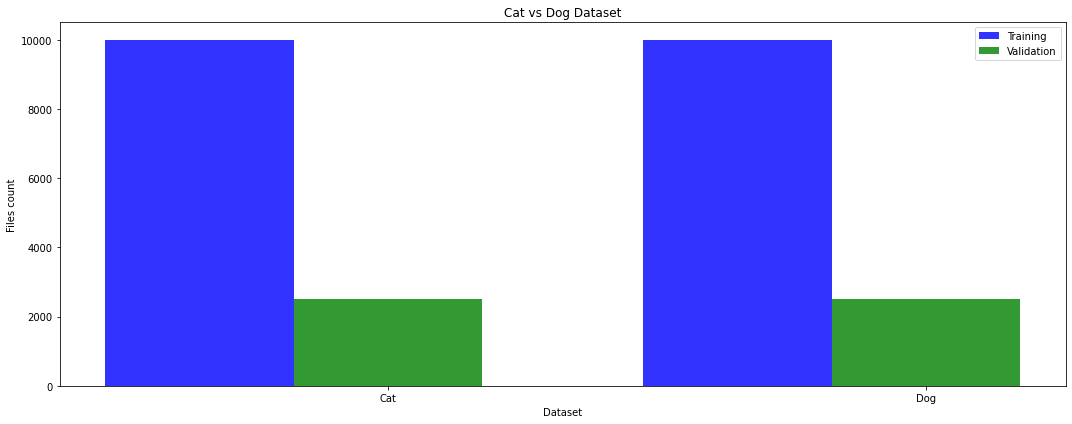

In [7]:
# Datasets
cats_dir = os.path.join(TRAINING_DIR,"cat")
dogs_dir = os.path.join(TRAINING_DIR,"dog")

cats_val_dir = os.path.join(VALIDATION_DIR,"cat")
dogs_val_dir = os.path.join(VALIDATION_DIR,"dog")

total_cats_train_images = len(os.listdir(cats_dir))
total_dogs_train_images = len(os.listdir(dogs_dir))
total_training_images = total_cats_train_images + total_dogs_train_images

total_cats_validation_images = len(os.listdir(cats_val_dir))
total_dogs_validation_images = len(os.listdir(dogs_val_dir))
total_validation_images = total_cats_validation_images + total_dogs_validation_images
total_training_images_classes = len(os.listdir(TRAINING_DIR))
total_validation_images_classes = len(os.listdir(VALIDATION_DIR))

print("total training cat's images:", total_cats_train_images)
print("total training dog's' images:", total_dogs_train_images)
print("total training images:", total_training_images)
print("\n")
print("total validation cat's images:", total_cats_validation_images)
print("total validation dog's' images:", total_dogs_validation_images)
print("total validation images:", total_validation_images)
print("\n")
print("total training dataset's Classes:", total_training_images_classes)
print("total validation dataset's Classes:", total_validation_images_classes)
print("\n")

# print("Frist 10 file names:\n")
# cats_files = os.listdir(cats_dir)[:10]
# print(cats_files)
# print("\n")

# dogs_files = os.listdir(dogs_dir)[:10]
# print(dogs_files)
# print("\n")

n_groups = 2
train_bar = (total_cats_train_images, total_dogs_train_images)
val_bar = (total_cats_validation_images, total_dogs_validation_images)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, train_bar, bar_width,
alpha=opacity,
color='b',
label='Training')

rects2 = plt.bar(index + bar_width, val_bar, bar_width,
alpha=opacity,
color='g',
label='Validation')

plt.xlabel('Dataset')
plt.ylabel("Files count")
plt.title('Cat vs Dog Dataset')
plt.xticks(index + bar_width, ('Cat', 'Dog'))
plt.legend()

plt.tight_layout()
plt.show()

### Some Pics

Training Dataset

In [8]:
print(TRAINING_DIR)

../../../Datasets/cats-vs-dogs/working/train/


../../../Datasets/cats-vs-dogs/working/train/**/*.jpg
(374, 500, 3)
(348, 500, 3)
(375, 499, 3)
(220, 305, 3)
(499, 499, 3)
(373, 500, 3)
(375, 499, 3)
(499, 459, 3)
(365, 349, 3)


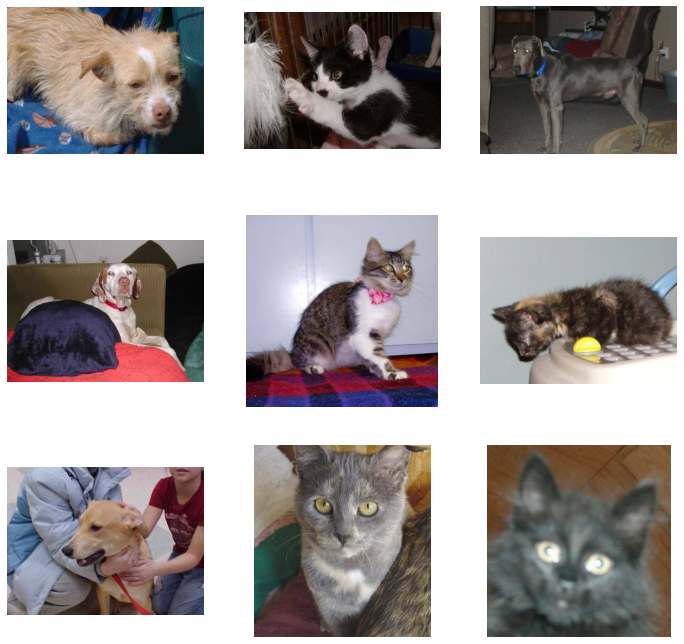

In [9]:
training_images_dir = TRAINING_DIR + "**/*.jpg"
print(training_images_dir)
training_images = glob.glob(training_images_dir)
plt.figure(figsize=(12, 12))    
for i in range(1, 10):
    training_image = np.random.choice(training_images)
    training_image_RGB = cv2.imread(training_image)[...,::-1]
    print(training_image_RGB.shape)
    plt.subplot(3, 3, i)
    plt.imshow(training_image_RGB)
    plt.axis('off')

Preprocess Images
- Image randam augmentation

In [10]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    brightness_range = (0.5, 1.1),
    horizontal_flip = True,
    fill_mode = "nearest"
)

validation_datagen = ImageDataGenerator(
        rescale = 1./255
)

In [14]:
BATCH_SIZE = 32
IMG_WIDTH = 300
IMG_HEIGHT = 300
CHANNEL = 3

print("\nTraining Dataset")
train_ds = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    class_mode = "binary",
    batch_size = BATCH_SIZE,
)
print("\nValidation Dataset")
validation_ds = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    class_mode = "binary",
    batch_size = BATCH_SIZE,
)
print("\nClass Indices:")
print(train_ds.class_indices)


Training Dataset
Found 20000 images belonging to 2 classes.

Validation Dataset
Found 5000 images belonging to 2 classes.

Class Indices:
{'cat': 0, 'dog': 1}


### Display Augmented Images

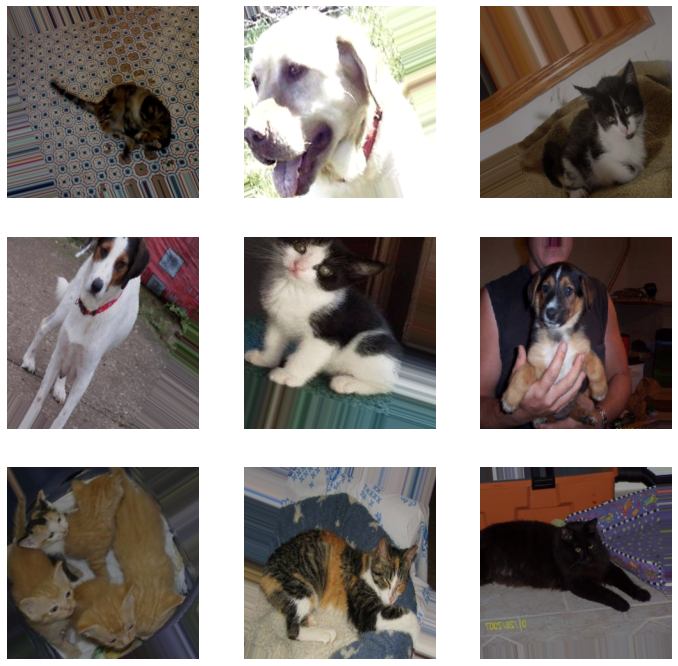

In [15]:
plt.figure(
    figsize = (12, 12)
)

for i in range (1, 10):
    img, label = train_ds.next()
    plt.subplot(3, 3, i)
    plt.imshow(img[0])
    plt.axis("Off")

### Model Building

In [16]:
model = Sequential([
    
    Conv2D(32, (3,3), activation= "relu",
           input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNEL)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(512, (3,3), activation = "relu"),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(256, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid")
    
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 298, 298, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 147, 147, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)       

### Callbacks

In [25]:
class theCallBacks(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if((logs.get("val_accuracy")>0.9) and (logs.get("val_loss")<0.2)):
            print("\nValidation Accuracy> 0.9 & Validation Loss < 0.2\nCancelling training!")
            self.model.stop_training = True

callback_on_metrics = theCallBacks()

reduce_lr = ReduceLROnPlateau(
                    monitor='val_loss', 
                    factor=0.5,
                    patience=2, 
                    verbose = 1,
                    cooldown = 1,
                    min_lr=0.0001)

### Defining Loss Function, Optimizer, Desired Metrics

In [26]:
loss_func = BinaryCrossentropy()
optimizer = RMSprop(learning_rate=0.005)


model.compile(
    loss = loss_func,
    optimizer = optimizer,
    metrics = ["accuracy"]
)

In [27]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [28]:
class LearningRateLogger(Callback):
    def __init__(self):
        super().__init__()
        self._supports_tf_logs = True

    def on_epoch_end(self, epoch, logs=None):
        if logs is None or "learning_rate" in logs:
            return
        logs["learning_rate"] = self.model.optimizer.lr
        
# source: https://stackoverflow.com/questions/49127214/keras-how-to-output-learning-rate-onto-tensorboard

### Train the model

In [29]:
num_epochs = 50
steps_per_epoch = total_training_images // BATCH_SIZE

history = model.fit(
    train_ds,
    epochs = num_epochs,
    validation_data = validation_ds,
    verbose = 1,
    steps_per_epoch = steps_per_epoch,
    callbacks = [reduce_lr,
                 callback_on_metrics,
                 LearningRateLogger(),
                 tensorboard_callback,
                ]
)

Epoch 1/50
625/625 [==============================] - 364s 581ms/step - loss: 0.8015 - accuracy: 0.5508 - val_loss: 0.7433 - val_accuracy: 0.6118
Epoch 2/50
625/625 [==============================] - 358s 573ms/step - loss: 0.6194 - accuracy: 0.6559 - val_loss: 0.5398 - val_accuracy: 0.7220
Epoch 3/50
625/625 [==============================] - 369s 589ms/step - loss: 0.5495 - accuracy: 0.7231 - val_loss: 0.5584 - val_accuracy: 0.7166
Epoch 4/50
625/625 [==============================] - 365s 584ms/step - loss: 0.5024 - accuracy: 0.7587 - val_loss: 0.4833 - val_accuracy: 0.7920
Epoch 5/50
625/625 [==============================] - 362s 579ms/step - loss: 0.4530 - accuracy: 0.7890 - val_loss: 1.0880 - val_accuracy: 0.6264
Epoch 6/50
625/625 [==============================] - 376s 601ms/step - loss: 0.3875 - accuracy: 0.8296 - val_loss: 0.4058 - val_accuracy: 0.8192
Epoch 7/50
625/625 [==============================] - 386s 617ms/step - loss: 0.3565 - accuracy: 0.8432 - val_loss: 0.4033 -

In [31]:
model.save("catvsdog")

INFO:tensorflow:Assets written to: catvsdog\assets


### Inline TensorBoard

In [32]:
# %tensorboard --logdir logs/fit

### Prompt TensorBoard in new window

After runnning below line, nagivate to http://localhost:8088/
Run before train, so you can refresh and see updates during training.

In [33]:
# %tensorboard --logdir logs/fit/ --host localhost --port 8088

In [34]:
history.history;

In [35]:
print("Train Accuracy:{:.3f}".format(history.history['accuracy'][-1]))
print("Validation/Test Accuracy:{:.3f}".format(history.history['val_accuracy'][-1]))

Train Accuracy:0.906
Validation/Test Accuracy:0.927


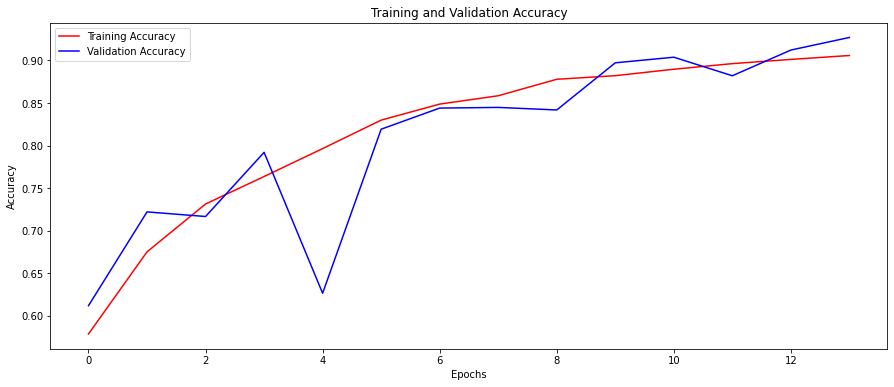

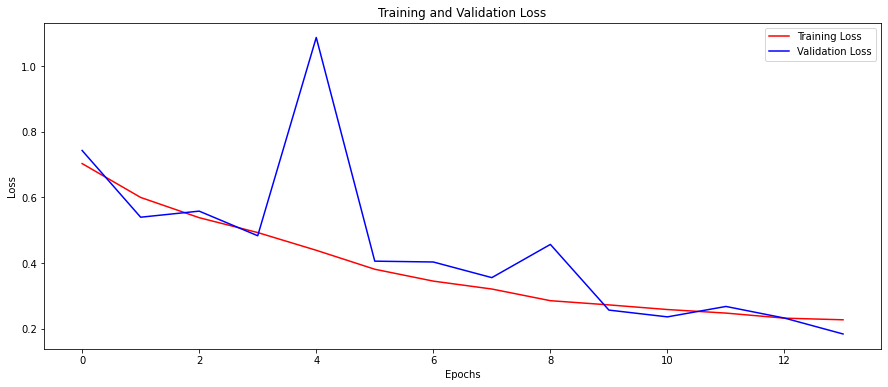

<Figure size 1080x432 with 0 Axes>

In [48]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label = "Training Accuracy")
plt.plot(epochs, val_acc, "b", label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "r", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.tight_layout()
plt.show()

### For Testing Data

- Making inference/predictions

In [37]:
from tensorflow.keras.models import load_model
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

#from sklearn.metrics import roc_curve

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6) # (w, h)

DATASETS_PATH = "../../../Datasets/cats-vs-dogs/working/"
TEST_FNAME = "test/"
TEST_DIR = os.path.join(DATASETS_PATH,TEST_FNAME)

model = load_model("catvsdog")

In [38]:
Dtest = os.listdir(TEST_DIR)
Dtest = sorted(Dtest,key=lambda x: int(os.path.splitext(x)[0]))
df_test = pd.DataFrame({
    "filename" : Dtest
})

In [39]:
BATCH_SIZE = 32
IMG_WIDTH = 300
IMG_HEIGHT = 300

test_datagen = ImageDataGenerator(
        rescale = 1./255
)

test_generator = test_datagen.flow_from_dataframe(
        df_test,
        TEST_DIR,
        x_col = "filename",
        y_col = None,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=True,
        color_mode="rgb"
)

Found 12500 validated image filenames.


### Predict Test Set

Since using Sigmoid activation function with 1 node/neuron as last layer, we need to self classify the classes with probability given.

In [40]:
predicted = model.predict(test_generator)

In [41]:
predicted_classes = np.round(predicted).astype(int)
df_test["category"] = predicted_classes
df_test["category"] = df_test["category"].replace({0 : "cat", 1 : "dog"}) # Sigmoid [0, 1], if 1 means class 1, 0 means class 0
df_test["confidence"] = predicted

# Since Non-Cat will have extremely low proba, use 1 - proba for dog's proba.
df_test.loc[df_test["category"] == "cat", "confidence"] = 1 - df_test.loc[df_test["category"] == "cat", "confidence"] 

In [42]:
df_test.head()

,filename,category,confidence
0,1.jpg,dog,0.999636
1,2.jpg,dog,0.806189
2,3.jpg,cat,0.998634
3,4.jpg,dog,0.966910
4,5.jpg,dog,0.904568


### Show Model Accuracy

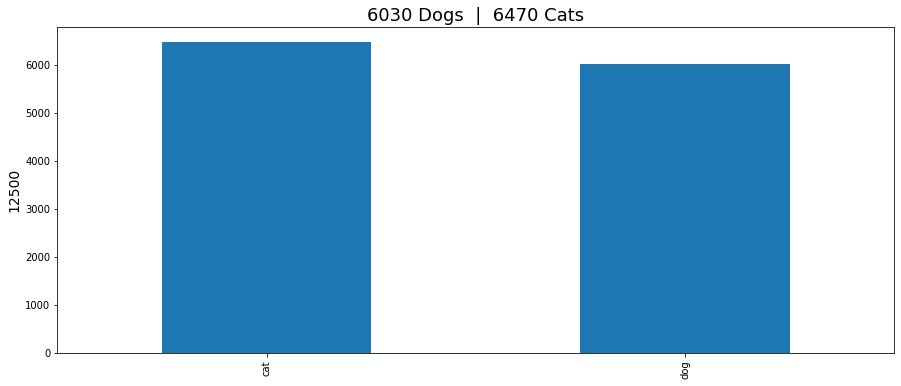

In [43]:
df_test['category'].value_counts().plot.bar()
plt.ylabel(len(df_test), fontsize = 14)
plt.title(str(len(df_test[df_test['category'] == 'dog']))+" Dogs  |  "+str((len(df_test[df_test['category'] == 'cat'])))+" Cats", fontsize=18)
plt.show()

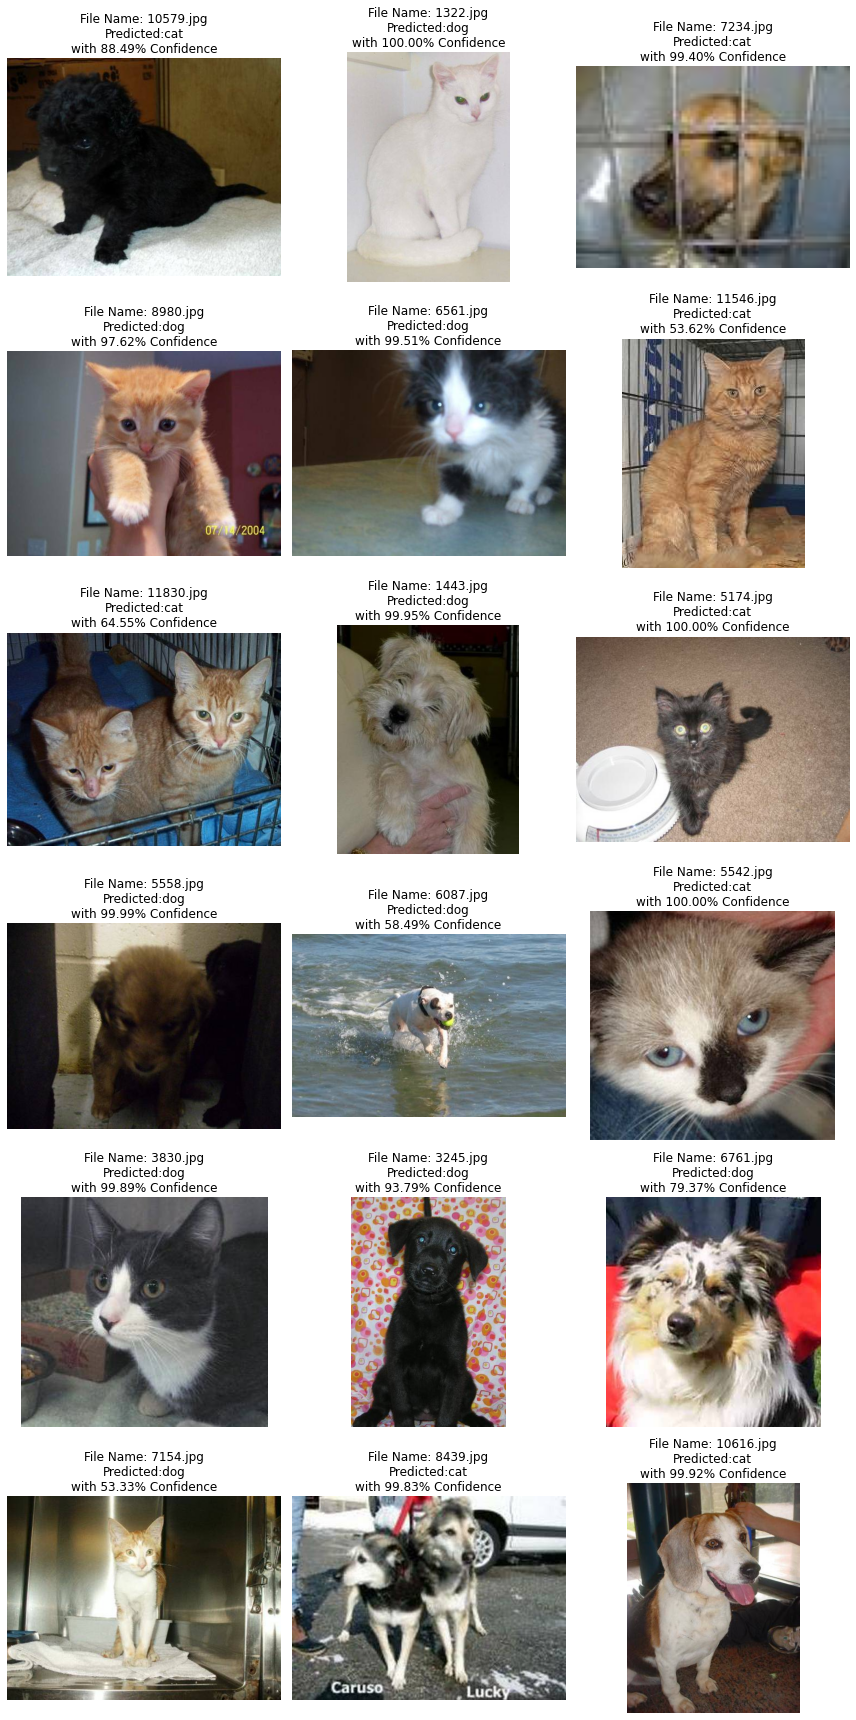

In [44]:
sample_test = df_test.sample(n = 18)
sample_test.reset_index(drop=True, inplace=True)
sample_test.head()

plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    confidence = row['confidence']
    img = cv2.imread(TEST_DIR+filename)[...,::-1]
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.title("File Name: {x}\nPredicted:{y}\nwith {cfn:.2f}% Confidence"
              .format(
                  x=filename, 
                  y = category, 
                  cfn = confidence*100)
             )
    plt.axis("Off")
plt.tight_layout()
plt.show()

In [45]:
submission_df = df_test.copy().drop("confidence",1)
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

###### Thanks for reading!